https://github.com/dimitri-yatsenko/point-cloud-registration

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from scipy.stats import gaussian_kde

In [2]:
import point_cloud_registration as pcr

In [3]:
points1 = np.load('data/Animal1_Day1_points.npy')[:1000]
points2 = np.load('data/Animal1_Day1_points.npy')[:1000]

In [4]:
# subselect
points1 = points1[np.random.rand(points1.shape[0]) < 0.9]
points2 = points2[np.random.rand(points2.shape[0]) < 0.9]

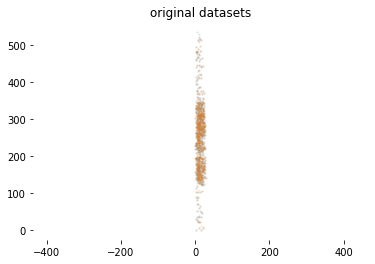

In [5]:
plt.scatter(*points1[:,:2].T, s=2, alpha=0.1)
plt.scatter(*points2[:,:2].T, s=2, alpha=0.1)
plt.axis('equal')
plt.box(False)
plt.title('original datasets');

In [6]:

# crop and scale datasets differently
points1 = points1[points1[:,1] < 0.6 * points1[:,1].max(), :]
points1 *= 1.2

# rotate and translate the second set
alpha = 0.1
rotation = [
    [np.cos(alpha), -np.sin(alpha), 0],
    [np.sin(alpha), np.cos(alpha), 0],
    [0, 0, 1]]
points2 = points2 @ rotation

points2 = points2[points2[:,1] < 0.7 * points2[:,1].max(), :]
points2 = points2[points2[:,0] < 0.6 * points2[:,0].max(),:]

points2 += np.array([500, -100, 30])

Text(0.5, 1.0, 'transformed datasets')

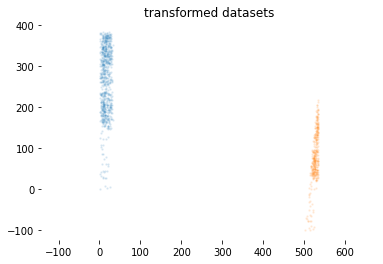

In [7]:
plt.scatter(*points1[:,:2].T, s=2, alpha=0.1)
plt.scatter(*points2[:,:2].T, s=2, alpha=0.1)
plt.axis('equal')
plt.box(False)
plt.title('transformed datasets')

In [8]:
tetras1 = pcr.make_normal_tetras(points1)
tetras2 = pcr.make_normal_tetras(points2)

In [9]:
pcr.compute_canonical_features(tetras1)
#pcr.remove_common_tetras(tetras1)

computing tetra features: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3423/3423 [00:12<00:00, 277.76it/s]


In [10]:
pcr.compute_canonical_features(tetras2)
#pcr.remove_common_tetras(tetras2)

computing tetra features: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 865/865 [00:03<00:00, 263.20it/s]


Text(0.5, 0.98, 'feature space')

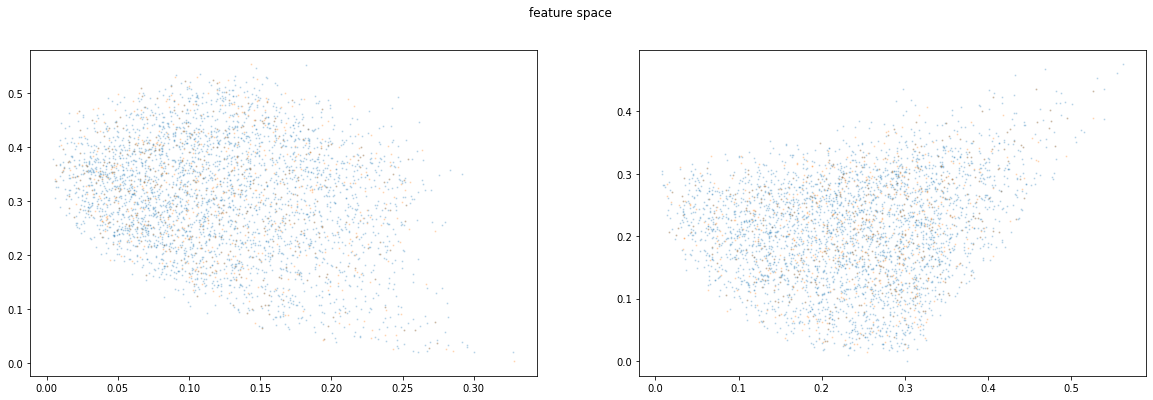

In [11]:
F1 = tetras1['features']
F2 = tetras2['features']

fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax[0].scatter(*F1[:,[0,1]].T, s=1, alpha=0.2)
ax[0].scatter(*F2[:,[0,1]].T, s=1, alpha=0.2)

ax[1].scatter(*F1[:,[2,3]].T, s=1, alpha=0.2)
ax[1].scatter(*F2[:,[2,3]].T, s=1, alpha=0.2)

#ax[2].scatter(*F1[:,[4,5]].T, s=1, alpha=0.2)
#ax[2].scatter(*F2[:,[4,5]].T, s=1, alpha=0.2)

fig.suptitle('feature space')

In [12]:
distances, matches = pcr.match_features(tetras1, tetras2)

In [13]:
ix = ~np.isinf(distances)
distances = distances[ix]
matches = np.stack(matches[ix])[:,0]
pcr.select_tetras(tetras2, ix)


In [14]:
# eliminate matches with large disparities
min_disparity = np.array([
    pcr.min_disparity(c1, c2)
    for c1, c2 in zip(
        tetras1['norm_coords'][matches], 
        tetras2['norm_coords'])]) < 0.01

matches = matches[ix]
pcr.select_tetras(tetras2, ix)


/Users/dimitri/opt/miniconda3/envs/benv/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


Text(0.5, 0, 'relative scale')

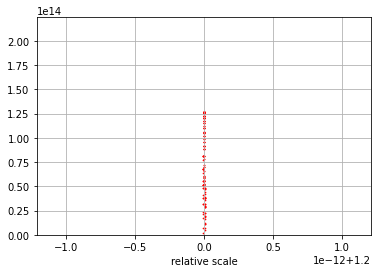

In [15]:
# vote based on scale
N1 = tetras1['norms']
N2 = tetras2['norms']

scale = N1[matches][:,0,0] / N2[:,0,0] 
plt.hist(scale, 100, density=True)

density = gaussian_kde(scale)(scale)
mode = scale[np.argmax(density)]

plt.scatter(scale, density, s=0.5, c='r')
plt.grid(True)
plt.xlabel('relative scale')


In [16]:
mode

1.1999999999999986

In [17]:
# remove matches with other scales
ix = abs(scale/mode - 1) < 0.03
matches = matches[ix]
pcr.select_tetras(tetras2, ix)

In [18]:
q, r = np.unique(matches, return_inverse=True)
matches = matches[r]
pcr.select_tetras(tetras2, r)
pcr.select_tetras(tetras1, matches)

In [19]:
#

In [20]:
tetras2['means'].shape

(211, 1, 3)

In [ ]:
C1 = tetras1['coords'].reshape((-1, 3))
C2 = tetras2['coords'].reshape((-1, 3))

In [ ]:
plt.scatter(C1[:,0], C1[:,1], s=2, alpha=0.2)
plt.scatter(C2[:,0], C2[:,1], s=2, alpha=0.2)

In [ ]:
M1 = C1.mean(axis=0, keepdims=True)
M2 = C2.mean(axis=0, keepdims=True)
C1 -= M1
C2 -= M2
N1 = np.linalg.norm(C1, axis=0, keepdims=True)
N2 = np.linalg.norm(C2, axis=0, keepdims=True)
C1 /= N1
C2 /= N2

In [ ]:
R, D = pcr.ortho_procrustes(C1, C2)

In [ ]:
R

In [ ]:
CC2 = D * C2 @ R.T

In [ ]:
plt.scatter(C1[:,0], C1[:,1], s=2, alpha=0.2)
plt.scatter(C2[:,0], C2[:,1], s=2, alpha=0.2)